# Optimizing Python in the Real World: NumPy, Numba, & the NUFFT

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.
A github repo with some of the code appearing below can be found at http://github.com/jakevdp/nufftpy/.*

<!-- PELICAN_BEGIN_SUMMARY -->

Donald Knuth famously quipped that "premature optimization is the root of all evil."
The reasons are straightforward: optimized code tends to be much more difficult to read and debug than simpler implementations of the same algorithm, and optimizing too early leads to greater costs down the road.
In the Python world, there is another cost to optimization: optimized code often is written in a compiled language like Fortran or C, and this leads to barriers to its development, use, and deployment.

Too often, tutorials about optimizing Python use trivial or toy examples which may not map well to the real world.
I've certainly been [guilty](https://jakevdp.github.io/blog/2012/08/24/numba-vs-cython/) of this [myself](https://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2/).
Here, I'm going to take a different route: in this post I will outline the process of understanding, implementing, and optimizing a non-trivial algorithm in Python, in this case the [Non-uniform Fast Fourier Transform](http://www.cims.nyu.edu/cmcl/nufft/nufft.html) (NUFFT).
Along the way, we'll dig into the process of optimizing Python code, and see how a relatively straightforward pure Python implementation, with a little help from [Numba](http://numba.pydata.org), can be made to nearly match the performance of a highly-optimized Fortran implementation of the same algorithm.

<!-- PELICAN_END_SUMMARY -->

## Why a Python Implementation?

First, I want to answer the inevitable question: why spend the time to make a Python implementation of an algorithm that's already out there in Fortran?
The reason is that I've found in my research and teaching that pure-Python implementations of algorithms are far more valuable than C or Fortran implementations, even if they might be a bit slower.
This is for a number of reasons:

- **Pure-Python code is easier to read, understand, and contribute to.** Good Python implementations are much higher-level than C or Fortran, and abstract-away loop indices, bit twiddling,  workspace arrays, and other sources of code clutter. A typical student reading good Python code can immediately understand and modify the algorithm, while the same student would be lost trying to understand typical optimized Fortran code.

- **Pure-python packages are much easier to install than Python-wrapped C or Fortran code.** This is especially true on non-Linux systems. Fortran in particular can require some installation prerequisites that are non-trivial for many users. In practice, I've seen people give up on better tools when there is an installation barrier for those tools.

- **Pure-python code often works for many data types.** Because of the way it is written, pure Python code is often automatically applicable to single or double precision, and perhaps even to extensions to complex numbers. For compiled packages, supporting and compiling for all possible types can be a burden.

- **Pure-python is easier to use at scale.** Because it does not require complicated installation, pure Python packages can be much easier to install on cloud VMs and/or shared clusters for computation at scale. If you can easily pip-install a pure-Python package on a VM, then services like AWS and TravisCI are much easier to set up.

Certainly code speed will overcome these considerations if the performance gap is great enough, but I've found that for many applications a pure Python package, cleverly designed and optimized, can be made fast enough that these larger considerations win-out. The challenge is making the Python fast. We'll explore this below.

## Background: The Non-Uniform Fast Fourier Transform

The Fast Fourier Transform (FFT) is perhaps the most important and fundamental of modern numerical algorithms.
It provides a fast, $O[N\log N]$ method of computing the discrete Fourier transform:
$$
Y_k^\pm = \sum_{n=0}^{N-1} y_n e^{\pm i k n / N}
$$
You can read more about the FFT in [my previous post](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/) on the subject.

One important limitation of the FFT is that it requires that input data be evenly-spaced: that is, we can think of the values $y_n$ as samples of a function $y_n = y(x_n)$ where $x_n = x_0 + n\Delta x$ is a regular grid of points.
But what about when your grid is not uniform?
That is, what if you want to compute this result:
$$
Y_k^\pm = \sum_{j=1}^N y(x_j) e^{\pm i k x_j}
$$
where $y(x)$ is evaluated at an arbitrary set of points $x_j$?
In this case, the FFT is no longer directly applicable, and you're stuck using a much slower $O[N^2]$ direct summation.

Stuck, that is, until the NUFFT came along.

The NUFFT is a clever algorithm which converts the non-uniform transform into an approximate uniform transform, not with error-prone interpolation, but instead using a clever "gridding" operation motivated by the convolution theorem.
If you'd like to read about the algorithm in detail, the Courant Institute's [NUFFT page](http://www.cims.nyu.edu/cmcl/nufft/nufft.html) has a nice set of resources.

Below we'll take a look at implementing this algorithm in Python.

## Direct Non-Uniform Fourier Transform

When developing optimized code, it is important to start with something easy to make sure you're on the right track.
Here we'll start with a straightforward direct version of the non-uniform Fourier transform.
We'll allow non-uniform inputs $x_j$, but compute the output on a grid of $M$ evenly-spaced frequencies in the range $-M/2 \le f/\delta f < M/2$.
This is what the NUFFT group calls the *Type-1 NUFFT*.

First we'll implement ``nufftfreqs()``, which returns the frequency grid for a given $M$, and ``nudft()`` which computes the non-uniform discrete Fourier transform using a slow direct method. The arguments for the latter include ``iflag``, which is a positive or negative number indicating the desired sign of the exponent:

In [19]:
from __future__ import print_function, division
import numpy as np

def nufftfreqs(M, df=1):
    """Compute the frequency range used in nufft for M frequency bins"""
    return df * np.arange(-(M // 2), M - (M // 2))


def nudft(x, y, M, df=1.0, iflag=1):
    """Non-Uniform Direct Fourier Transform"""
    sign = -1 if iflag < 0 else 1
    return (1 / len(x)) * np.dot(y, np.exp(sign * 1j * nufftfreqs(M, df) * x[:, np.newaxis]))

Again, I can't emphasize this enough: when writing fast code, start with a slow-and-simple version of the code which you *know* gives the correct result, and then optimize from there.

## Comparing to the Fortran NUFFT

We can double-check that this is producing the desired result by comparing to the Fortran NUFFT implementation, using Python wrappers written by Dan Foreman-Mackey, available at [http://github.com/dfm/python-nufft/](http://github.com/dfm/python-nufft/):

In [20]:
# Install nufft from http://github.com/dfm/python-nufft/
from nufft import nufft1 as nufft_fortran

x = 100 * np.random.random(1000)
y = np.sin(x)

Y1 = nudft(x, y, 1000)
Y2 = nufft_fortran(x, y, 1000)

np.allclose(Y1, Y2)

True

The results match! A quick check shows that, as we might expect, the Fortran algorithm is orders of magnitude faster:

In [21]:
%timeit nudft(x, y, 1000)
%timeit nufft_fortran(x, y, 1000)

10 loops, best of 3: 143 ms per loop
1000 loops, best of 3: 339 µs per loop


On top of this, for $N$ points and $N$ frequencies, the Fortran NUFFT will scale as $O[N\log N]$, while our simple implementation will scale as $O[N^2]$, making the difference even greater as $N$ increases! Let's see if we can do better.

## NUFFT with Python

Here we'll attempt a pure-Python version of the fast, FFT-based NUFFT.
We'll follow the basics of the algorithm presented on the NUFFT page, using NumPy broadcasting tricks to push loops into the compiled layer of NumPy.
For later convenience, we'll start by defining a utility to compute the grid parameters as detailed in the NUFFT paper.

In [22]:
def _compute_grid_params(M, eps):
    # Choose Msp & tau from eps following Dutt & Rokhlin (1993)
    if eps <= 1E-33 or eps >= 1E-1:
        raise ValueError("eps = {0:.0e}; must satisfy "
                         "1e-33 < eps < 1e-1.".format(eps))
    ratio = 2 if eps > 1E-11 else 3
    Msp = int(-np.log(eps) / (np.pi * (ratio - 1) / (ratio - 0.5)) + 0.5)
    Mr = max(ratio * M, 2 * Msp)
    lambda_ = Msp / (ratio * (ratio - 0.5))
    tau = np.pi * lambda_ / M ** 2
    return Msp, Mr, tau


def nufft_python(x, c, M, df=1.0, eps=1E-15, iflag=1):
    """Fast Non-Uniform Fourier Transform with Python"""
    Msp, Mr, tau = _compute_grid_params(M, eps)
    N = len(x)

    # Construct the convolved grid
    ftau = np.zeros(Mr, dtype=c.dtype)
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    mm = np.arange(-Msp, Msp)
    for i in range(N):
        xi = (x[i] * df) % (2 * np.pi)
        m = 1 + int(xi // hx)
        spread = np.exp(-0.25 * (xi - hx * (m + mm)) ** 2 / tau)
        ftau[(m + mm) % Mr] += c[i] * spread

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau

Let's compare this to the previous results.
For convenience, we'll define a single routine which validates the results and times the execution:

In [23]:
from time import time

def test_nufft(nufft_func, M=1000, Mtime=100000):
    # Test vs the direct method
    print(30 * '-')
    name = {'nufft1':'nufft_fortran'}.get(nufft_func.__name__,
                                          nufft_func.__name__)
    print("testing {0}".format(name))
    rng = np.random.RandomState(0)
    x = 100 * rng.rand(M + 1)
    y = np.sin(x)
    for df in [1, 2.0]:
        for iflag in [1, -1]:
            F1 = nudft(x, y, M, df=df, iflag=iflag)
            F2 = nufft_func(x, y, M, df=df, iflag=iflag)
            assert np.allclose(F1, F2)
    print("- Results match the DFT")
    
    # Time the nufft function
    x = 100 * rng.rand(Mtime)
    y = np.sin(x)
    times = []
    for i in range(5):
        t0 = time()
        F = nufft_func(x, y, Mtime)
        t1 = time()
        times.append(t1 - t0)
    print("- Execution time (M={0}): {1:.2g} sec".format(Mtime, np.median(times)))

In [24]:
test_nufft(nufft_python)
test_nufft(nufft_fortran)

------------------------------
testing nufft_python
- Results match the DFT
- Execution time (M=100000): 1.3 sec
------------------------------
testing nufft_fortran
- Results match the DFT
- Execution time (M=100000): 0.042 sec


The good news is that our Python implementation works; the bad news is that it remains several orders of magnitude slower than the Fortran result!

Let's make it faster.

### Making Code Faster: Line Profiling

We know that our Python function is slow, but we'd like to determine *where* this speed bottleneck lies.
One convenient way to do this is with the ``line_profiler`` utility, a Python/IPython addon which can be installed using
```
$ pip install line_profiler
```
Once it's installed, we can load the line profiler extension into the IPython notebook using the ``%load_ext`` magic function:

In [25]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


With the line profiler loaded, the ``%lprun`` magic function is now available, which we can use to profile our function line-by-line.
In order to display these results here, we'll save them to file and then use ``%cat`` to view the file:

In [26]:
%lprun -s -f nufft_python -T lp_results.txt nufft_python(x, y, 1000)
%cat lp_results.txt


*** Profile printout saved to text file u'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 0.031398 s
File: <ipython-input-22-cce3eafad61b>
Function: nufft_python at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def nufft_python(x, c, M, df=1.0, eps=1E-15, iflag=1):
    15                                               """Fast Non-Uniform Fourier Transform with Python"""
    16         1           27     27.0      0.1      Msp, Mr, tau = _compute_grid_params(M, eps)
    17         1            1      1.0      0.0      N = len(x)
    18                                           
    19                                               # Construct the convolved grid
    20         1           54     54.0      0.2      ftau = np.zeros(Mr, dtype=c.dtype)
    21         1            2      2.0      0.0      Mr = ftau.shape[0]
    22         1            3      3.0      0.0      hx = 2 * np.pi / Mr
    23         1     

The output shows us where, line-by-line, the algorithm is spending the most time.
We see that nearly 99% of the execution time is being spent in the single ``for`` loop at the center of our code.
The loop is so expensive that even the FFT computation is just a trivial piece of the cost!
This is actually pretty typical: due to dynamic typing, loops are generally very slow in Python.

One of the surest strategies for speeding-up your code is to use broadcasting tricks in NumPy to remove these kinds of large loops: you can read one of my course lectures on the subject [here](http://nbviewer.ipython.org/url/www.astro.washington.edu/users/vanderplas/Astr599_2014/notebooks/11_EfficientNumpy.ipynb).
We'll do this next.

## NUFFT with NumPy Broadcasting

Let's rewrite the above implementation and use broadcasting tricks to elliminate the loops.
Because of the structure of this problem, the approach is a bit complicated here, but it turns out that we can take advantage here of the little-known ``at()`` method of NumPy's ufunc.
Briefly,
```python
>>> np.add.at(x, i, y)
```
is similar to
```python
>>> x[i] += y
```
but works as desired even if the incides ``i`` have duplicate entries.

Using this, we can adjust our implementation as follows:

In [27]:
def nufft_numpy(x, y, M, df=1.0, iflag=1, eps=1E-15):
    """Fast Non-Uniform Fourier Transform"""
    Msp, Mr, tau = _compute_grid_params(M, eps)
    N = len(x)

    # Construct the convolved grid ftau:
    # this replaces the loop used above
    ftau = np.zeros(Mr, dtype=y.dtype)
    hx = 2 * np.pi / Mr
    xmod = (x * df) % (2 * np.pi)
    m = 1 + (xmod // hx).astype(int)
    mm = np.arange(-Msp, Msp)
    mpmm = m + mm[:, np.newaxis]
    spread = y * np.exp(-0.25 * (xmod - hx * mpmm) ** 2 / tau)
    np.add.at(ftau, mpmm % Mr, spread)

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau

Let's test it:

In [28]:
test_nufft(nufft_numpy)
test_nufft(nufft_python)
test_nufft(nufft_fortran)

------------------------------
testing nufft_numpy
- Results match the DFT
- Execution time (M=100000): 0.34 sec
------------------------------
testing nufft_python
- Results match the DFT
- Execution time (M=100000): 1.3 sec
------------------------------
testing nufft_fortran
- Results match the DFT
- Execution time (M=100000): 0.045 sec


It worked! We gained around a factor of 4 speedup in replacing the Python loop with the ``np.add.at()`` call.
Still, though, we're sitting at about a factor of 10 slower than the Fortran version.
The problem is that the ``np.add.at()`` call here requires construction of some very large and costly temporary arrays.
If we want a faster execution time, we need to further optimize that main loop, and we can't do this with NumPy alone.

## Optimization with Numba

When NumPy broadcasting tricks aren't enough, there are a few options: you can write Fortran or C code directly, you can use [Cython](http://cython.org), [Weave](http://docs.scipy.org/doc/scipy/reference/tutorial/weave.html), or other tools as a bridge to include compiled snippets in your script, or you can use a tool like [Numba](http://cython.org) to speed-up your loops without ever leaving Python.

Numba is a slick tool which runs Python functions through an LLVM just-in-time (JIT) compiler, leading to orders-of-magnitude faster code for certain operations.
In this case, we need to optimize what amounts to a nested for-loop, so Numba fits the bill perfectly.
For clarity, we'll pull-out the grid construction code that we want to optimize, and write it as follows:

In [29]:
import numba

# nopython=True means an error will be raised
# if fast compilation is not possible.
@numba.jit(nopython=True)
def build_grid(x, c, tau, Msp, ftau):
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    for i in range(x.shape[0]):
        xi = x[i] % (2 * np.pi)
        m = 1 + int(xi // hx)
        for mm in range(-Msp, Msp):
            ftau[(m + mm) % Mr] += c[i] * np.exp(-0.25 * (xi - hx * (m + mm)) ** 2 / tau)
    return ftau


def nufft_numba(x, c, M, df=1.0, eps=1E-15, iflag=1):
    """Fast Non-Uniform Fourier Transform with Numba"""
    Msp, Mr, tau = _compute_grid_params(M, eps)
    N = len(x)

    # Construct the convolved grid
    ftau = build_grid(x * df, c, tau, Msp,
                      np.zeros(Mr, dtype=c.dtype))

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau

Let's test this now:

In [30]:
test_nufft(nufft_numba)
test_nufft(nufft_fortran)

------------------------------
testing nufft_numba
- Results match the DFT
- Execution time (M=100000): 0.097 sec
------------------------------
testing nufft_fortran
- Results match the DFT
- Execution time (M=100000): 0.042 sec


Much better! We're now within about a factor of 3 of the Fortran speed, and we're still writing pure Python!

Having plucked all the low-hanging fruit, any further optimization will now be very low-level: that is, thinking about things like reduction of the number of ``exp()`` evaluations through application of mathematical identities.
This type of careful logic is one reason the Fortran implementation is so fast, and many of these low-level strategies are discussed in the NUFFT paper linked above.

To gain some more speed, we can follow their advice and optimize the expressions at this level by precomputing expensive expressions and recombining these expressions later:
This makes the algorithm a bit more obfuscated, but it does lead to some faster execution.
Here is an example of this:

In [31]:
import numba

@numba.jit(nopython=True)
def build_grid_fast(x, c, tau, Msp, ftau, E3):
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    
    # precompute some exponents
    for j in range(Msp + 1):
        E3[j] = np.exp(-(np.pi * j / Mr) ** 2 / tau)
        
    # spread values onto ftau
    for i in range(x.shape[0]):
        xi = x[i] % (2 * np.pi)
        m = 1 + int(xi // hx)
        xi = (xi - hx * m)
        E1 = np.exp(-0.25 * xi ** 2 / tau)
        E2 = np.exp((xi * np.pi) / (Mr * tau))
        E2mm = 1
        for mm in range(Msp):
            ftau[(m + mm) % Mr] += c[i] * E1 * E2mm * E3[mm]
            E2mm *= E2
            ftau[(m - mm - 1) % Mr] += c[i] * E1 / E2mm * E3[mm + 1]
    return ftau


def nufft_numba_fast(x, c, M, df=1.0, eps=1E-15, iflag=1):
    """Fast Non-Uniform Fourier Transform with Numba"""
    Msp, Mr, tau = _compute_grid_params(M, eps)
    N = len(x)

    # Construct the convolved grid
    ftau = build_grid_fast(x * df, c, tau, Msp,
                           np.zeros(Mr, dtype=c.dtype),
                           np.zeros(Msp + 1, dtype=x.dtype))

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau

Let's test the result:

In [32]:
test_nufft(nufft_numba_fast)
test_nufft(nufft_fortran)

------------------------------
testing nufft_numba_fast
- Results match the DFT
- Execution time (M=100000): 0.038 sec
------------------------------
testing nufft_fortran
- Results match the DFT
- Execution time (M=100000): 0.045 sec


This is looking good! With a bit of effort we are now within about 25% of the Fortran speed, and we retain all the advantages of having pure Python code!

## Let's try making numba faster

Can I make numba even faster with parallel code and declaring data types?

On my system -- no :'(

but numba is just as fast as fortran when the number of elements is large

In [33]:
import numba
from numba import prange, float64, int64

@numba.jit(float64[:](float64[:], float64[:], float64, int64, float64[:], float64[:]),
           nopython=True, parallel=True)
def build_grid_faster(x, c, tau, Msp, ftau, E3):
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    
    # precompute some exponents
    for j in prange(Msp + 1):
        E3[j] = np.exp(-(np.pi * j / Mr) ** 2 / tau)
        
    # spread values onto ftau
    for i in range(x.shape[0]):
        xi = x[i] % (2 * np.pi)
        m = 1 + int(xi // hx)
        xi = (xi - hx * m)
        E1 = np.exp(-0.25 * xi ** 2 / tau)
        E2 = np.exp((xi * np.pi) / (Mr * tau))
        E2mm = 1
        for mm in range(Msp):
            ftau[(m + mm) % Mr] += c[i] * E1 * E2mm * E3[mm]
            E2mm *= E2
            ftau[(m - mm - 1) % Mr] += c[i] * E1 / E2mm * E3[mm + 1]
    return ftau

@numba.jit(nopython=True, parallel=True)
def _compute_grid_params_faster(M, eps):
    # Choose Msp & tau from eps following Dutt & Rokhlin (1993)
    if eps <= 1E-33 or eps >= 1E-1:
        raise ValueError("must satisfy ")
    ratio = 2 if eps > 1E-11 else 3
    Msp = int(-np.log(eps) / (np.pi * (ratio - 1) / (ratio - 0.5)) + 0.5)
    Mr = max(ratio * M, 2 * Msp)
    lambda_ = Msp / (ratio * (ratio - 0.5))
    tau = np.pi * lambda_ / M ** 2
    return Msp, Mr, tau


@numba.jit(nopython=True, parallel=True)
def nufftfreqs_faster(M):
    """Compute the frequency range used in nufft for M frequency bins"""
    return np.arange(-(M // 2), M - (M // 2))


@numba.jit(nopython=False, parallel=True)
def nufft_numba_faster(x, c, M, df=1.0, eps=1E-15, iflag=1):
    """Fast Non-Uniform Fourier Transform with Numba"""
    Msp, Mr, tau = _compute_grid_params_faster(M, eps)
    N = len(x)
    # Msp, Mr are int
    # tau is float
    
    # x is a float
    # c is a float
    # float
    # float
    # Construct the convolved grid
#     print(np.shape(x), np.dtype(x))
#     print(np.shape(c), np.dtype(c))
#     print(np.shape(tau), np.type(tau))
    ftau = build_grid_faster(x * df, c, tau, Msp,
                           np.zeros(Mr, dtype=c.dtype),
                           np.zeros(Msp + 1, dtype=x.dtype))

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs_faster(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau

def test_nufft_faster(MM=1000, Mtime=100000):
    # Test vs the direct method
    print(30 * '-')
#     name = {'nufft1':'nufft_fortran'}.get(nufft_numba_faster.__name__,
#                                           nufft_numba_faster.__name__)
    print("testing numba faster")
    rng = np.random.RandomState(0)
    x = 100 * rng.rand(1000 + 1)
    y = np.sin(x)
    for df in [1, 2.0]:
        for iflag in [1, -1]:
            F1 = nudft(x, y, 1000, df=df, iflag=iflag)
            F2 = nufft_numba_faster(x, y, 1000, df=df, iflag=iflag)
            assert np.allclose(F1, F2)
    print("- Results match the DFT")
    
    # Time the nufft function
    x = 100 * rng.rand(Mtime)
    y = np.sin(x)
    times = []
    for i in range(5):
        t0 = time()
        F = nufft_numba_faster(x, y, Mtime)
        t1 = time()
        times.append(t1 - t0)
    print("- Execution time (M={0}): {1:.2g} sec".format(Mtime, np.median(times)))


In [34]:
# rng = np.random.RandomState(0)
# x = 100 * rng.rand(1000 + 1)
test_nufft_faster(nufft_numba_faster)

------------------------------
testing numba faster
- Results match the DFT
- Execution time (M=100000): 0.036 sec


## Final Timing Comparison

For good measure, let's take a look at the scaling with $M$ for all the fast algorithms we created.
We'll compute the times for a range of input sizes for each algorithm.
Be aware that the following code will take several minutes to run!

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
# use seaborn for nice default plot settings
import seaborn; seaborn.set()

In [36]:
Mrange = (2 ** np.arange(3, 18)).astype(int)

t_python = []
t_numpy = []
t_numba = []
t_numba_fast = []
t_fortran = []
t_numba_faster = []

for M in Mrange:
    x = 100 * np.random.random(M)
    c = np.sin(x)
    
    t1 = %timeit -oq nufft_python(x, c, M)
    t2 = %timeit -oq nufft_numpy(x, c, M)
    t3 = %timeit -oq nufft_numba(x, c, M)
    t4 = %timeit -oq nufft_numba_fast(x, c, M)
    t5 = %timeit -oq nufft_fortran(x, c, M)
    t6 = %timeit -oq nufft_numba_faster(x,c,M)
    
    t_python.append(t1.best)
    t_numpy.append(t2.best)
    t_numba.append(t3.best)
    t_numba_fast.append(t4.best)
    t_fortran.append(t5.best)
    t_numba_faster.append(t6.best)

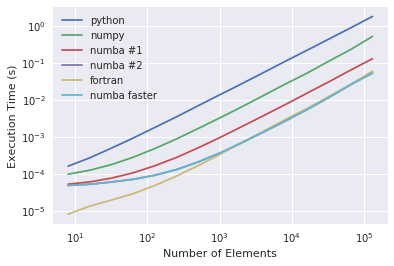

In [37]:
plt.loglog(Mrange, t_python, label='python')
plt.loglog(Mrange, t_numpy, label='numpy')
plt.loglog(Mrange, t_numba, label='numba #1')
plt.loglog(Mrange, t_numba_fast, label='numba #2')
plt.loglog(Mrange, t_fortran, label='fortran')
plt.loglog(Mrange, t_numba_fast, label='numba faster')
plt.legend(loc='upper left')
plt.xlabel('Number of Elements')
plt.ylabel('Execution Time (s)');

As we see, all the algorithms scale as $\sim O[N\log N]$ in the large $N$ limit, albeit with very different constants of proportionality.
Our final optimized Numba implementation nearly matches the Fortran version as $N$ grows large, and because it is written in pure Python, it retains all the advantages of pure Python code listed above.
For that benefit, I think the cost of a ~25% slow-down is well worth it!

## Conclusion

I hope you've enjoyed this exploration of how to write fast numerical code in pure Python.
As you think about writing efficient implementations of useful algorithms, I invite you to consider the points I listed above: in particular, how difficult will it be for your users to install, read, modify, and contribute to your code?
In the long run, this may be much more important than shaving a few milliseconds off the execution time.
Writing a fast implementation of a useful algorithm is an excellent and useful pursuit, but we should be careful to not forget the costs that come along with such optimization.

If you're interested in using the pure-Python NUFFT implementation, I've adapted much of the above code in a repository at [http://github.com/jakevdp/nufftpy/](http://github.com/jakevdp/nufftpy/).
It contains a packaged and unit-tested version of some of the above code, as well as a (hopefully) growing compendium of related routines.

<small>
This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/NUFFT.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/NUFFT.ipynb).
</small>